# Gauge how well the clusters separate the data

#### Suggested approach:

Coherence is not meant to work with clusters, only topics. It can only work with either 
- an existing LDA model, in which case it does something clever
- A corpus, a dictionary and a list of [sets of?] key words representing topics

To make models from different sources comparable, it could be quite tricky

The other tool I could use is Silhouette scores, but they'll only work really for flat clustering models.

TODO
- Implement coherence against tokens
- Implement Silhouette scoring against TF-IDF representations
- Implement relevance scoring for retrieval of top tokens

In [41]:
import re
import json
import gensim

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem.porter import *
from lib.helper import *

# Define which stemmer to use in the pipeline later
stemmer = PorterStemmer()

# Useful flatten function from Alex Martelli on https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
flatten = lambda l: [item for sublist in l for item in sublist]

%matplotlib inline

In [18]:
def load_evaluate_corpus(data_path):
    """ Helper - process a corpus csv, return its coherence scores """
    df = pd.read_csv(data_path)
    
    df["tokens"] = df["clean_text"].apply(preprocess_desc)
    
    print("Number of topics is {}".format(len(pd.unique(df['cluster']))))
    return get_corpus_model_coherence(df)

## Testing requirements of manual coherence scoring

In [19]:
df = pd.read_csv("working/disaster_clustered_lda.csv")
df["tokens"] = df["clean_text"].apply(preprocess_desc)

coherences, mod1, mod2, topics_lengths = get_corpus_model_coherence(df)

In [26]:
topic_features = pd.DataFrame({"topic_coherence": list(mod1.get_coherence_per_topic()),
                               "topic_sizes": list(topics_lengths.values())})

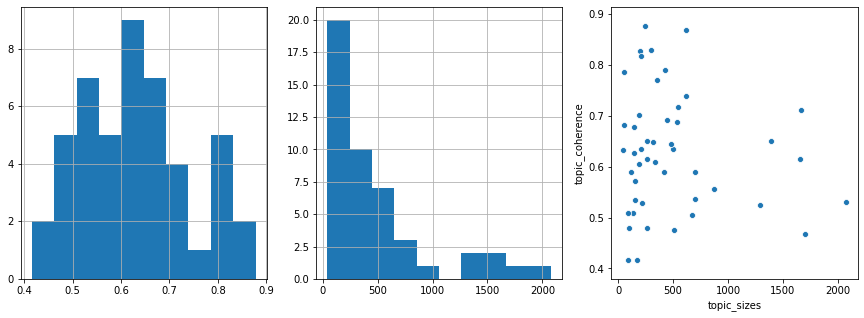

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

pd.Series(mod1.get_coherence_per_topic()).hist(ax=axs[0])
pd.Series(topics_lengths).hist(ax=axs[1])
sns.scatterplot(x='topic_sizes', y='topic_coherence', data=topic_features, ax=axs[2])

### Create corpus, dictionary and lists of all tokens for each topic

In [5]:
corpus_files = ["disaster_clustered_lda.csv",
                "disaster_clustered_w2v_pca.csv",
                "disaster_clustered_w2v_direct.csv",
                "disaster_clustered_louvain.csv"]
#                "disaster_clustered_bigclam.csv",
#                "disaster_clustered_cliques.csv"]

In [6]:
coherences = {}

for file in corpus_files:
    print("Processing: {}".format(file))
    coherences[file.strip(".csv")] = load_evaluate_corpus("working/" + file)
    print(coherences[file.strip(".csv")])

Processing: disaster_clustered_lda.csv
Number of topics is 47
{'c_v': 0.6289230271130697, 'c_npmi': 0.09982127239084664}
Processing: disaster_clustered_w2v_pca.csv
Number of topics is 93
{'c_v': 0.5728062583393208, 'c_npmi': 0.08599018781913917}
Processing: disaster_clustered_w2v_direct.csv
Number of topics is 71
{'c_v': 0.5561880170677628, 'c_npmi': 0.07761587021062656}
Processing: disaster_clustered_louvain.csv
Number of topics is 149
{'c_v': 0.6545162168508325, 'c_npmi': 0.13240052828941928}


In [7]:
coherences

{'disaster_clustered_lda': {'c_v': 0.6289230271130697,
  'c_npmi': 0.09982127239084664},
 'disaster_clustered_w2v_pca': {'c_v': 0.5728062583393208,
  'c_npmi': 0.08599018781913917},
 'disaster_clustered_w2v_direct': {'c_v': 0.5561880170677628,
  'c_npmi': 0.07761587021062656},
 'disaster_clustered_louvain': {'c_v': 0.6545162168508325,
  'c_npmi': 0.13240052828941928}}